# Analyze Hyperparameter Sweeps

In [30]:
import pathlib
import sys
sys.path.append(str(pathlib.Path("__file__").absolute().parents[1]))

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, accuracy_score, balanced_accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import wandb

from src.util.definitions import PRED_DIR, DATA_ROOT
from utils import get_runs_as_list

In [29]:
summary_list, config_list, tag_list, name_list = get_runs_as_list(filters={"jobType": "hparam_optimization"})

run_df = pd.json_normalize(config_list).merge(pd.json_normalize(summary_list), left_index=True, right_index=True)
run_df["tags"] = tag_list

run_df.head()

,name,run_id,run_group,num_labels,accelerator,target_names,data_hash_key,experiment_id,label_binarizer,atom_feature_size,...,val/f1_micro,train/auroc_target_binary_B,train/f1_micro,val/auroc_macro,val/auroc_target_binary_A,train/auroc_macro,train/auroc_target_binary_A,train/auroc_target_binary_C,val/auroc_target_binary_C,tags
0,FFN,2023-11-14-190224_518314_fold3,2023-11-14-190224_518314,3,gpu,"[binary_A, binary_B, binary_C]",bf5dd14a,JG1161,LabelBinarizer(),66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(1D_80,)"
1,FFN,2023-11-14-190224_518314_fold2,2023-11-14-190224_518314,3,gpu,"[binary_A, binary_B, binary_C]",bf5dd14a,JG1161,LabelBinarizer(),66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(1D_80,)"
2,FFN,2023-11-14-190224_518314_fold1,2023-11-14-190224_518314,3,gpu,"[binary_A, binary_B, binary_C]",bf5dd14a,JG1161,LabelBinarizer(),66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(1D_80,)"
3,FFN,2023-11-14-190224_518314_fold0,2023-11-14-190224_518314,3,gpu,"[binary_A, binary_B, binary_C]",bf5dd14a,JG1161,LabelBinarizer(),66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(1D_80,)"
4,FFN,2023-11-14-184035_856868_fold8,2023-11-14-184035_856868,3,gpu,"[binary_A, binary_B, binary_C]",bf5dd14a,JG1161,LabelBinarizer(),66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(1D_80,)"


In [ ]:
# see the unique configurations
architecture_cols = ["name", "tags", "decoder.global_features", "training.task", "experiment_id"]
run_df[architecture_cols].applymap(lambda x: tuple(x) if isinstance(x, list) else x).drop_duplicates().sort_values(by="experiment_id")

In [ ]:
# reduce df to columns with differences
nunique = run_df.applymap(lambda x: tuple(x) if isinstance(x, list) else x).nunique()
cols_to_drop = nunique[nunique == 1].index
run_df = run_df.drop(cols_to_drop, axis=1)

In [21]:
# get all runs belonging to a certain hyperparameter sweep
run_df.loc[run_df["experiment_id"] == "JG1111"].columns

Index(['name', 'run_id', 'run_group', 'accelerator', 'data_hash_key',
       'experiment_id', 'global_feature_size', 'decoder.depth',
       'decoder.hidden_size', 'decoder.dropout_ratio',
       'decoder.global_features', 'encoder.depth', 'encoder.graph_type',
       'encoder.hidden_size', 'encoder.dropout_ratio', 'optimizer.lr',
       'optimizer.lr_scheduler.lr_min', 'decoder.gamma', 'decoder.reg_alpha',
       'decoder.reg_lambda', 'decoder.learning_rate',
       'global_featurizer_state_dict_path', 'decoder.C', 'train/f1_macro',
       'val/recall_target_binary_B', 'val/precision_target_binary_C',
       'val/precision_macro', 'train/avgPrecision_macro',
       'train/f1_target_binary_A', 'val/balanced_accuracy_macro',
       'train/precision_target_binary_C', 'train/loss',
       'val/precision_target_binary_A', 'val/avgPrecision_target_binary_B',
       'val/balanced_accuracy_target_binary_A', 'train/precision_macro',
       'train/recall_target_binary_A', 'val/accuracy_target_b

In [35]:
df_plot = run_df.loc[run_df["experiment_id"] == "JG1130"]

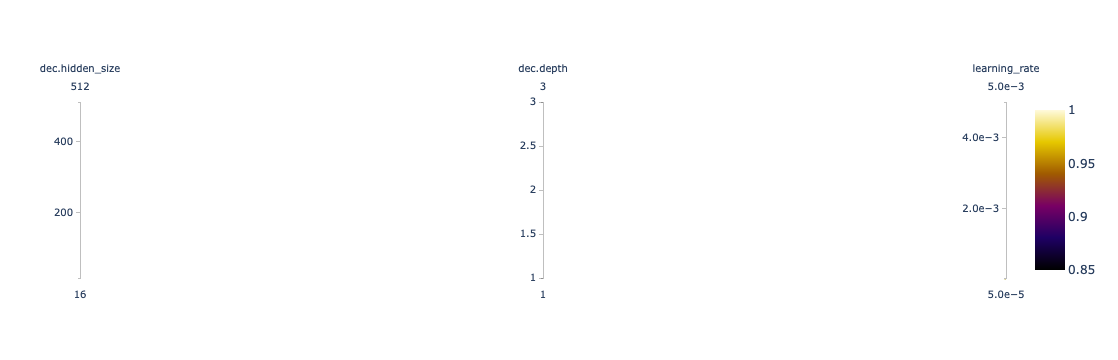

In [33]:
# FFN hparams
fig = go.Figure(data=
   go.Parcoords(
       line = dict(color = df_plot['val/avgPrecision_macro'],
           colorscale = 'Electric',
           showscale = True,
           cmin = 0.85,
           cmax = 1.0),
       dimensions = list([
           dict(range = [16, 512],
                label = 'dec.hidden_size', values = df_plot['decoder.hidden_size']),
           dict(range = [1, 3],
                label = 'dec.depth', values = df_plot['decoder.depth']),
           dict(range = [5e-5, 5e-3],
                label = 'learning_rate', values = df_plot['optimizer.lr'], tickformat = '.1e'),
           # Add more variables as needed
       ])
   )
)
fig.show()


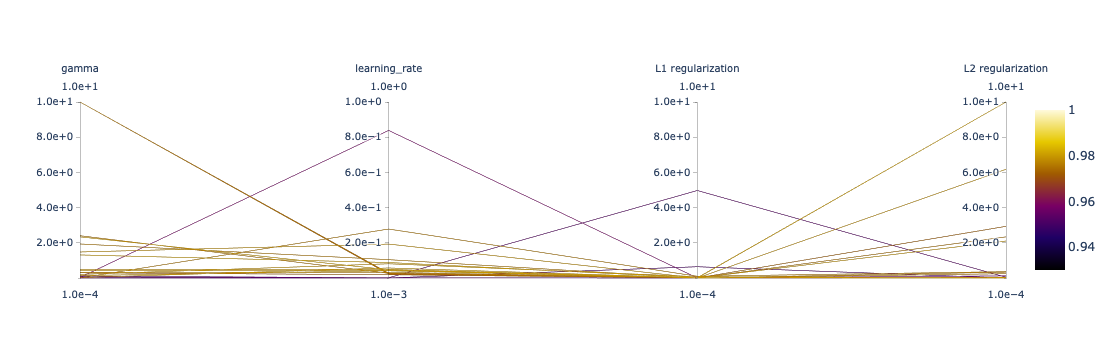

In [40]:
# XGB hparams
fig = go.Figure(data=
   go.Parcoords(
       line = dict(color = df_plot['val/avgPrecision_macro'],
           colorscale = 'Electric',
           showscale = True,
           cmin = 0.93,
           cmax = 1.0),
       dimensions = list([
           dict(range = [1e-4, 10],
                label = 'gamma', values = df_plot['decoder.gamma'], tickformat = '.1e'),
           dict(range = [1e-3, 1],
                label = 'learning_rate', values = df_plot['decoder.learning_rate'], tickformat = '.1e'),
           dict(range = [1e-4, 10],
                label = 'L1 regularization', values = df_plot['decoder.reg_alpha'], tickformat = '.1e'),
           dict(range = [1e-4, 10],
                label = 'L2 regularization', values = df_plot['decoder.reg_lambda'], tickformat = '.1e'),
       ])
   )
)
fig.show()


In [2]:
# just look at the best hparams now

summary_list, config_list, tag_list, name_list = get_runs_as_list(filters={"jobType": "hparam_best"})

run_df = pd.json_normalize(config_list).merge(pd.json_normalize(summary_list), left_index=True, right_index=True)
run_df["tags"] = tag_list
run_df["run_id"] = name_list
run_df["run_group"] = [s.rsplit("_", maxsplit=1)[0] for s in name_list]
run_df["Model+Features"] = run_df["name"] + "/" + run_df["decoder.global_features"].str.join("+").str.replace("None", "CGR")

run_df.head()

,name,run_id,run_group,num_labels,accelerator,target_names,data_hash_key,experiment_id,label_binarizer,atom_feature_size,...,train/loss_target_binary_C,test/loss_target_binary_C,train/loss_target_binary_A,val/loss_target_binary_B,test/loss_target_binary_B,val/loss_target_binary_A,train/loss_target_binary_B,test/loss_target_binary_A,tags,Model+Features
0,D-MPNN,2023-11-14-051547_721457_fold8,2023-11-14-051547_721457,3,gpu,"[binary_A, binary_B, binary_C]",511fce28,JG1160,LabelBinarizer(),66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(0D,)",D-MPNN/RDKit
1,D-MPNN,2023-11-14-051547_721457_fold7,2023-11-14-051547_721457,3,gpu,"[binary_A, binary_B, binary_C]",511fce28,JG1160,LabelBinarizer(),66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(0D,)",D-MPNN/RDKit
2,D-MPNN,2023-11-14-051547_721457_fold6,2023-11-14-051547_721457,3,gpu,"[binary_A, binary_B, binary_C]",511fce28,JG1160,LabelBinarizer(),66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(0D,)",D-MPNN/RDKit
3,D-MPNN,2023-11-14-051547_721457_fold5,2023-11-14-051547_721457,3,gpu,"[binary_A, binary_B, binary_C]",511fce28,JG1160,LabelBinarizer(),66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(0D,)",D-MPNN/RDKit
4,D-MPNN,2023-11-14-051547_721457_fold4,2023-11-14-051547_721457,3,gpu,"[binary_A, binary_B, binary_C]",511fce28,JG1160,LabelBinarizer(),66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(0D,)",D-MPNN/RDKit


In [18]:
# only look at the hyperparameters now
hparams = run_df.drop_duplicates(subset="experiment_id")[
    ["experiment_id", 
     "encoder.depth",  # all GNNs
     "encoder.hidden_size",  # all GNNs
     "decoder.depth",  # all NNs
     "decoder.hidden_size",  # all NNs
     "optimizer.lr",  # all NNs
     "decoder.gamma",  # XGB
     "decoder.learning_rate",  # XGB
     "decoder.reg_alpha",  # XGB
     "decoder.reg_lambda",  # XGB
     "decoder.C",  # Logistic Regression
    ]]
hparams.head()

,experiment_id,encoder.depth,encoder.hidden_size,decoder.depth,decoder.hidden_size,optimizer.lr,decoder.gamma,decoder.learning_rate,decoder.reg_alpha,decoder.reg_lambda,decoder.C
0,JG1160,5.0,643.0,2.0,94.0,0.001191,NaN,NaN,NaN,NaN,NaN
9,JG1159,5.0,18.0,1.0,128.0,0.001019,NaN,NaN,NaN,NaN,NaN
18,JG1158,6.0,624.0,2.0,52.0,0.002106,NaN,NaN,NaN,NaN,NaN
27,JG1157,6.0,1421.0,2.0,92.0,0.000752,NaN,NaN,NaN,NaN,NaN
36,JG1156,6.0,259.0,2.0,29.0,0.001471,NaN,NaN,NaN,NaN,NaN


In [41]:
hparams.query("experiment_id == 'JG1131'").squeeze()

experiment_id              JG1131
encoder.depth                 NaN
encoder.hidden_size           NaN
decoder.depth                 NaN
decoder.hidden_size           NaN
optimizer.lr                  NaN
decoder.gamma              0.0001
decoder.learning_rate    0.362268
decoder.reg_alpha        0.155739
decoder.reg_lambda           10.0
decoder.C                     NaN
Name: 261, dtype: object

In [100]:
def get_hparams(experiment_id):
    flexible_hparams = {
        "D-MPNN": [
            "encoder.depth",
            "encoder.hidden_size",
            "decoder.depth",
            "decoder.hidden_size",
            "optimizer.lr",
        ],
        "GCN": [
            "encoder.depth",
            "encoder.hidden_size",
            "decoder.depth",
            "decoder.hidden_size",
            "optimizer.lr",
        ],
        "AttentiveFP": [
            "encoder.depth",
            "encoder.hidden_size",
            "decoder.depth",
            "decoder.hidden_size",
            "optimizer.lr",
        ],
        "GraphSAGE": [
            "encoder.depth",
            "encoder.hidden_size",
            "decoder.depth",
            "decoder.hidden_size",
            "optimizer.lr",
        ],
        "FFN": [
            "decoder.depth",
            "decoder.hidden_size",
            "optimizer.lr",
        ],
        "XGB": [
            "decoder.gamma",
            "decoder.learning_rate",
            "decoder.reg_alpha",
            "decoder.reg_lambda",
        ],
        "LogisticRegression": [
            "decoder.C",
        ],
    }
    api = wandb.Api()
    runs = api.runs("jugoetz/synferm-predictions", filters={"$and": [{"config.experiment_id": experiment_id}, {"jobType": "hparam_best"}]})

    config = { # we use the fact that all runs with one experiment_id have identical hparams
            k: v for k,v in pd.json_normalize(runs[0].config, sep=".").to_dict(orient='records')[0].items()
         if k in flexible_hparams[runs[0].config["name"]]
        }
    
    return config

In [131]:
get_hparams("JG1111")

{'decoder.gamma': 0.00471,
 'decoder.reg_alpha': 0.0005961,
 'decoder.reg_lambda': 10,
 'decoder.learning_rate': 0.02547}

In [104]:
data = []
for i in range(0,60):
    exp_id = f"JG11{i:02}"
    exp_data = {"experiment_id": exp_id}
    exp_data.update(get_hparams(exp_id))
    data.append(exp_data)
hparams = pd.DataFrame(data).convert_dtypes()

In [108]:
hparams = hparams.convert_dtypes()

In [119]:
# look at LogReg runs only
logreg = hparams.loc[~hparams["decoder.C"].isnull()].dropna(axis=1)
logreg

,experiment_id,decoder.C
6,JG1106,100.0
7,JG1107,0.01
8,JG1108,0.01
12,JG1112,0.01


In [128]:
# look at XGB runs only
xgb = hparams.loc[~hparams["decoder.gamma"].isnull()].dropna(axis=1)
xgb

,experiment_id,decoder.gamma,decoder.reg_alpha,decoder.reg_lambda,decoder.learning_rate
9,JG1109,0.001639,2.67,0.06708,0.3539
10,JG1110,10.0,10.0,0.3839,0.04248
11,JG1111,0.00471,0.000596,10.0,0.02547
28,JG1128,0.665303,3.216913,0.57315,0.58938
29,JG1129,0.0003,0.118056,0.097847,0.09802
30,JG1130,10.0,0.001109,0.332752,0.025713
31,JG1131,0.0001,0.155739,10.0,0.362268
32,JG1132,0.0001,10.0,0.000618,0.080665
33,JG1133,0.000152,10.0,0.23368,0.039
34,JG1134,10.0,0.0001,10.0,0.03701


<Axes: >

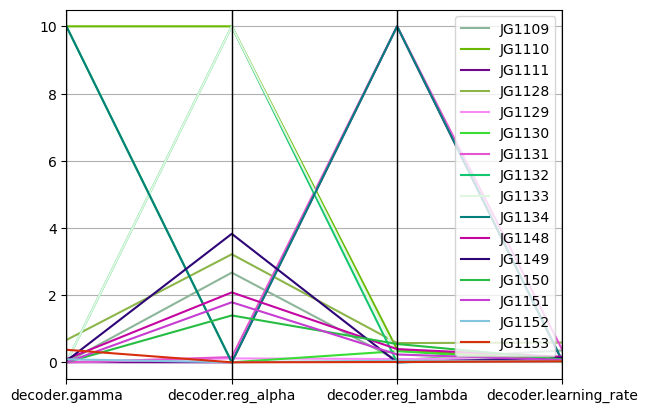

In [121]:
pd.plotting.parallel_coordinates(xgb, "experiment_id")

In [127]:
# look at FFN runs only
ffn = hparams.loc[(~hparams["optimizer.lr"].isnull()) & hparams["encoder.depth"].isnull()].dropna(axis=1)
ffn

,experiment_id,decoder.depth,decoder.hidden_size,optimizer.lr
15,JG1115,1,512,0.000181
16,JG1116,2,512,0.00027
17,JG1117,1,461,0.000661
18,JG1118,1,512,0.00005
19,JG1119,1,512,0.000097
20,JG1120,2,426,0.00005
25,JG1125,1,311,0.000086
26,JG1126,1,512,0.000166
27,JG1127,1,16,0.00005
36,JG1136,1,512,0.000954


In [125]:
# look at (all) GNN runs only
gnn = hparams.loc[~hparams["encoder.depth"].isnull()].dropna(axis=1)
gnn

,experiment_id,decoder.depth,decoder.hidden_size,encoder.depth,encoder.hidden_size,optimizer.lr
0,JG1100,2,113,4,1808,0.001339
1,JG1101,3,106,6,2048,0.000075
2,JG1102,1,34,4,439,0.000157
3,JG1103,2,35,3,326,0.000138
4,JG1104,3,88,3,799,0.00005
5,JG1105,1,60,4,542,0.00005
13,JG1113,2,72,3,100,0.000119
14,JG1114,2,92,3,64,0.000128
21,JG1121,2,69,3,64,0.000655
22,JG1122,3,104,3,64,0.000093


<Axes: >

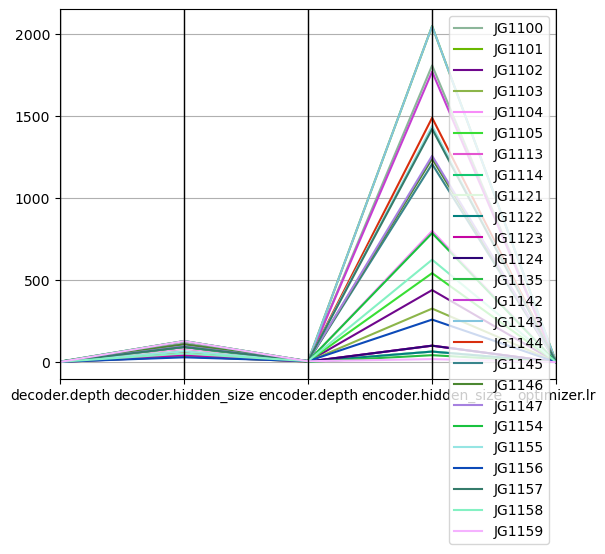

In [129]:
pd.plotting.parallel_coordinates(gnn, "experiment_id")